<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span><ul class="toc-item"><li><span><a href="#Software-and-conventions" data-toc-modified-id="Software-and-conventions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Software and conventions</a></span></li></ul></li><li><span><a href="#Data-sources" data-toc-modified-id="Data-sources-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data sources</a></span></li><li><span><a href="#Creating-the-geo_em_d01.nc-(geogrid)-file-to-define-the-domain" data-toc-modified-id="Creating-the-geo_em_d01.nc-(geogrid)-file-to-define-the-domain-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating the geo_em_d01.nc (geogrid) file to define the domain</a></span><ul class="toc-item"><li><span><a href="#geogrid.exe" data-toc-modified-id="geogrid.exe-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>geogrid.exe</a></span></li><li><span><a href="#Defining-domain-boundaries" data-toc-modified-id="Defining-domain-boundaries-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Defining domain boundaries</a></span></li><li><span><a href="#Exploring-the-WPS-geogrid.exe-utility-and-namelist.wps" data-toc-modified-id="Exploring-the-WPS-geogrid.exe-utility-and-namelist.wps-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exploring the WPS geogrid.exe utility and namelist.wps</a></span><ul class="toc-item"><li><span><a href="#Setting-up-the-lesson-directory" data-toc-modified-id="Setting-up-the-lesson-directory-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Setting up the lesson directory</a></span></li><li><span><a href="#Changing-the-domain-location-and-boundaries-in-WPS" data-toc-modified-id="Changing-the-domain-location-and-boundaries-in-WPS-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Changing the domain location and boundaries in WPS</a></span></li></ul></li><li><span><a href="#Making-the-geogrid-file" data-toc-modified-id="Making-the-geogrid-file-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Making the geogrid file</a></span></li><li><span><a href="#Inspecting-the-geogrid-file" data-toc-modified-id="Inspecting-the-geogrid-file-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Inspecting the geogrid file</a></span></li></ul></li></ul></div>

# Lesson - Defining the domain and model initial conditions

## Overview
This lesson covers two topics: creating your case-specific domain that will also be used throughout the WRF-Hydro system and defining static and initial conditions used for the land surface model. 

### Software and conventions
**This notebook is not intended to be used interactively and merely is used to create a static markdown document.**

This lesson uses the `wrfhydro/wps` docker utility, which can be obtained using the command `docker pull wrfhydro/wps`. 

Additionally, we will use the latest `Croton_NY_example_testcase.tar.gz` domain tarball for this lesson, which can be obtained from the latest WRF-Hydro release at https://github.com/NCAR/wrf_hydro_nwm_public/releases. 

All paths used in this lesson assume that the lesson materials are located under your home directory in a folder named `wrf-hydro-training`. 

## Data sources
WRF-Hydro leverages the extensive domain generation and geophysical dataset processing tools available in the WRF Preprocessing System (WPS). The geographical input data (e.g., land cover, soil texture, vegetation) are some of the primary datasets used by WRF-Hydro. The entire dataset collection can be obtained from the [WPS geographical input data download page](http://www2.mmm.ucar.edu/wrf/users/download/get_sources_wps_geog.html). However, these data are rather large (~50GB) and contain a number of datasets that are not used in most implementations of WRF-Hydro. To facilitate the domain generation process, the WRF-Hydro team has created a subset of the data by removing unnecessary data, removing resolutions of the data not commonly used, and limiting the areal extent of this subset to the Continental United States (CONUS). This is consistent with the availability of other datasets used in this tutorial. Thus, the dataset provided with the [wrfhydro/wps](https://hub.docker.com/r/wrfhydro/wps/) Docker container is considerably smaller than the complete WRF-WPS dataset.

## Creating the geo_em_d01.nc (geogrid) file to define the domain
### geogrid.exe
The WPS program *geogrid.exe* is used to create the *geo_em_d01.nc* file, hereafter referred to as the 'geogrid' file. The *geogrid.exe* program takes a Fortran namelist (*namelist.wps*) and the [WPS geographical input data](http://www2.mmm.ucar.edu/wrf/users/download/get_sources_wps_geog.html) as inputs and creates the geogrid file. However, the *geogrid.exe* program requires that WRF and WPS be built according to your system specification, and building WRF and WPS can be difficult on some systems. Additionally, much of the functionality of WRF and WPS is not utilized for creating a geogrid file for WRF-Hydro, and many of the options in the *namelist.wps* are not relevant to this process. Therefore, we have created a Docker container and Python command line utility to abstract much of the WRF/WPS complexity and simplify the process of creating a geogrid file for WRF-Hydro users. 

We will cover the steps to create the geogrid file using this method in the section 'Creating the geogrid file'. For more advanced usage please see the WPS documentation.

### Defining domain boundaries
The land surface model in WRF-Hydro operates on the domain defined within the geogrid file. The geogrid.exe program generates this file based upon input variables specified in the *namelist.wps* file. The first step to creating the geogrid file is to define our domain boundaries. The *geogrid.exe* program takes a centerpoint, x and y grid specifications, and other projection information to define a bounding box for the domain. If you do not already have coordinates, you can obtain them from Google Earth or a standard GIS system. However, for this tutorial we have supplied the coordinates for you and you may use the WRF-Hydro geogrid python command line utility to visualize the domain location and create the geogrid file given these coordinates.

### Exploring the WPS geogrid.exe utility and namelist.wps
The WPS *geogrid.exe* utility is controlled by options set in the *namelist.wps*. As previously stated, there are many options in the *namelist.wps* file that are not relevant to most WRF-Hydro users. For educational purposes, we will take a quick look at a full *namelist.wps* file and then discuss the relevant options used by the WRF-Hydro geogrid utility in more detail.

```&share
 wrf_core = 'ARW',
 max_dom = 1,
 start_date = '2006-08-16_12:00:00',
 end_date   = '2006-08-16_18:00:00',
 interval_seconds = 21600
 io_form_geogrid = 2,
/

&geogrid
 parent_id         =   1,
 parent_grid_ratio =   1,
 i_parent_start    =   1,
 j_parent_start    =   1,
 e_we              =  74,
 e_sn              =  61,
 !
 !!!!!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT NOTE !!!!!!!!!!!!!!!!!!!!!!!!!!!!
 ! The default datasets used to produce the HGT_M, GREENFRAC, 
 ! and LU_INDEX/LANDUSEF fields have changed in WPS v3.8. The HGT_M field
 ! is now interpolated from 30-arc-second USGS GMTED2010, the GREENFRAC 
 ! field is interpolated from MODIS FPAR, and the LU_INDEX/LANDUSEF fields 
 ! are interpolated from 21-class MODIS.
 !
 ! To match the output given by the default namelist.wps in WPS v3.7.1, 
 ! the following setting for geog_data_res may be used:
 !
 ! geog_data_res = 'gtopo_10m+usgs_10m+nesdis_greenfrac+10m','gtopo_2m+usgs_2m+nesdis_greenfrac+2m',
 !
 !!!!!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT NOTE !!!!!!!!!!!!!!!!!!!!!!!!!!!!
 !
 dx = 30000,
 dy = 30000,
 map_proj = 'lambert',
 ref_lat   =  34.83,
 ref_lon   = -81.03,
 truelat1  =  30.0,
 truelat2  =  60.0,
 stand_lon = -98.0,

 geog_data_res = 'default',
 geog_data_path = '/home/docker/WRF_WPS/utilities/geog_conus'
/

&ungrib
 out_format = 'WPS',
 prefix = 'FILE',
/

&metgrid
 fg_name = 'FILE'
 io_form_metgrid = 2, 
/
```

A full description of these options can be found in the WPS user guide at http://www2.mmm.ucar.edu/wrf/users/docs/user_guide_V3.9/users_guide_chap3.html. The options that are of interest to most WRF-Hydro users are the following:

**Table 1. WPS namelist options relevent to WRF-Hydro**

|Option|Description|
|------|-----------|
| e_we | The number of grid edges in the west-east dimension. The number of grid centers will be e_we-1. |
| e_sn | The number of grid edges in the south-north dimension. The number of grid centers will be e_sn-1. |
| ref_lat | A real value specifying the latitude part of a (latitude, longitude) center-point of the domain. |
| ref_lon | A real value specifying the longitude part of a (latitude, longitude) center-point of the domain. West longitudes are negative, and the value of ref_lon should be in the range [-180, 180]. |
| dx | A real value specifying the grid distance in the x-direction where the map scale factor is 1. The grid distance is in meters for the 'polar', 'lambert', and 'mercator' projection, and in degrees longitude for the 'lat-lon' projection. |
| dy | A real value specifying the grid distance in the y-direction where the map scale factor is 1. The grid distance is in meters for the 'polar', 'lambert', and 'mercator' projection, and in degrees latitude for the 'lat-lon' projection. |
| map_proj | A character string specifying the projection of the simulation domain. Accepted projections are 'lambert', 'polar', 'mercator', and 'lat-lon'. Default value is 'lambert'. |
| truelat1 | A real value specifying, the first true latitude for the Lambert conformal conic projection, or the only true latitude for the Mercator and polar stereographic projections. |
| truelat2 | A real value specifying, the second true latitude for the Lambert conformal conic projection. For all other projections, truelat2 is ignored. No default value. |
| stand_lon | A real value specifying, the longitude that is parallel with the y-axis in the Lambert conformal and polar stereographic projections. For the regular latitude-longitude projection, this value gives the rotation about the earth's geographic poles. No default value. |
| geog_data_res | A character string specifying a corresponding resolution or list of resolutions separated by + symbols of source data to be used when interpolating static terrestrial data to the grid. This string should contain a resolution matching a string preceding a colon in a rel_path or abs_path specification (see the description of GEOGRID.TBL options) in the GEOGRID.TBL file for each field. If a resolution in the string does not match any such string in a rel_path or abs_path specification for a field in GEOGRID.TBL, a default resolution of data for that field, if one is specified, will be used. If multiple resolutions match, the first resolution to match a string in a rel_path or abs_path specification in the GEOGRID.TBL file will be used. Default value is 'default'. |
| geog_data_path | A character string giving the path, either relative or absolute, to the directory where the geographical data directories may be found. This path is the one to which rel_path specifications in the GEOGRID.TBL file are given in relation to. No default value. |


To simplify the process of creating the geogrid file, these options are the only ones needed when using the WRF-Hydro geogrid Docker utility. 

Lets take a look at the namelist.wps file used by the `wrfhydro/wps` docker utility

```
&share
 wrf_core = 'ARW',
 max_dom = 1,
 start_date = '2006-08-16_12:00:00',
 end_date   = '2006-08-16_18:00:00',
 interval_seconds = 21600
 io_form_geogrid = 2,
/

&geogrid
 parent_id         =   1,
 parent_grid_ratio =   1,
 i_parent_start    =   1,
 j_parent_start    =   1,
 e_we              =  74,
 e_sn              =  61,
 !
 !!!!!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT NOTE !!!!!!!!!!!!!!!!!!!!!!!!!!!!
 ! The default datasets used to produce the HGT_M, GREENFRAC, 
 ! and LU_INDEX/LANDUSEF fields have changed in WPS v3.8. The HGT_M field
 ! is now interpolated from 30-arc-second USGS GMTED2010, the GREENFRAC 
 ! field is interpolated from MODIS FPAR, and the LU_INDEX/LANDUSEF fields 
 ! are interpolated from 21-class MODIS.
 !
 ! To match the output given by the default namelist.wps in WPS v3.7.1, 
 ! the following setting for geog_data_res may be used:
 !
 ! geog_data_res = 'gtopo_10m+usgs_10m+nesdis_greenfrac+10m','gtopo_2m+usgs_2m+nesdis_greenfrac+2m',
 !
 !!!!!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT NOTE !!!!!!!!!!!!!!!!!!!!!!!!!!!!
 !
 dx = 30000,
 dy = 30000,
 map_proj = 'lambert',
 ref_lat   =  34.83,
 ref_lon   = -81.03,
 truelat1  =  30.0,
 truelat2  =  60.0,
 stand_lon = -98.0,

 geog_data_res = 'default',
 geog_data_path = '/home/docker/WRF_WPS/utilities/geog_conus'
/

&ungrib
 out_format = 'WPS',
 prefix = 'FILE',
/

&metgrid
 fg_name = 'FILE'
 io_form_metgrid = 2, 
/
```

#### Setting up the lesson directory

**Step 1: Setup the directory for this lesson**
First, we need to create a directory to hold the inputs and outputs for this lesson.

In [1]:
%%bash
mkdir -p $HOME/wrf-hydro-training/lesson-wps

**Step 2: Download the example case.** 
    
The example case can be obtained from the WRF-Hydro release page at https://github.com/NCAR/wrf_hydro_nwm_public/releases

In [2]:
%%bash
cd $HOME/wrf-hydro-training/lesson-wps
wget https://github.com/NCAR/wrf_hydro_nwm_public/releases/download/v5.1.1-beta/croton_NY_example_testcase.tar.gz &>/dev/null
tar -xf croton_NY_example_testcase.tar.gz

#### Changing the domain location and boundaries in WPS
In this section we will make a few changes to the example case `namelist.wps` to demonstrate how to move the domain location and change the extent. **NOTE: Do not edit the *~/wrf-hydro-training/example_case/supplemental/namelist.wps* file because we will use this prepared namelist to create the example case geogrid file using WPS in a later section of this lesson**

In general, users want to generate the largest, highest-resolution model domain possible. Unfortunately, we are often constrained by available computational power or drive storage. These contraints usually define the acceptable grid sizes for us (*e_we*, *e_sn*). Therefore, once we know our domain center, we can play with *dx* and *dy* to cover our interested area.

We will edit the *dx* and *dy* options in the namelist to grow the size of the domain. We will leave all other options the same, which will simply increase the domain coverage but maintain the domain center and domain dimensions.

**Step 1: Visualize the original domain location.**

First let's create a basic map of the original example case domain location using the example case namelist.wps file *~/wrf-hydro-training/example_case/supplemental/namelist.wps* and the WRF-Hydro geogrid Python utility. You can get help on the arguments to the python utility by accessing its help.

In [3]:
%%bash
docker run wrfhydro/wps --help

usage: make_geogrid.py [-h] [--namelist_path NAMELIST_PATH]
                       [--output_dir OUTPUT_DIR] [--plot_only]
                       [--create_wrf_input]

Step 1: Pull the image docker pull wrfhydro/dev:conda Step 2: Create a
directory to bind-mount to Docker for passing files between your system and
docker mkdir /home/dockerMount Step 3: Create a namelist.wps file for your
domain using the above example as a starting point and save it in your mount
directory from step 1. Step 4: Run Docker invoking the python make_geogrid.py
utility with the required arguments. NOTE THE PATHS LISTED BELOW IN THE
ARUGMENT LIST ARE FOR THE DOCKER FILESYSTEM. ALSO NOTE THAT ALL PATHS MUST BE
ABSOLUTEdocker run -v <path-to-your-local-mount-folder>:/home/docker/mount
wrfhydro/wps --namelist_path /home/docker/mount/namelist.wps --output_dir
/home/docker/mount/ Note: Windows users will need to remove the \ from the end
of each line of the above commands.

optional arguments:
  -h, --help        

Note that the Docker utility entrypoint script takes 4 arguments, the first `--namelist_path` is the path to your *namelist.wps* file, the second `--output_dir` is the path to the directory to hold the output, and the third `--plot_only` is a boolean `True` or `False` indicating whether or not to plot the domain. If `plot_only` the utility will only plot the domain and not create the geogrid file. This option is useful for making changes to your domain location or extent. The fourth argument `--create_wrfinput` is a boolean `True` or `False` indicating whether or not to create a wrfinput initial conditions.

Now, let's create a plot of the original example case domain location.

In [4]:
%%bash
docker run -v $HOME/wrf-hydro-training/lesson-wps/:/home/docker/mount wrfhydro/wps \
--namelist_path /home/docker/mount/example_case/supplemental/namelist.wps \
--output_dir /home/docker/mount \
--plot_only

Proj4: +proj=lcc +units=meters +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=45.0 +lon_0=-97.0
Grid center x,y: [1849500.1972706 -108771.437837 ]
Grid center lat,lon: [ 58.50955341 -63.99173649]
Domain extent: [1842000.1972705964, 1857000.1972705964, -116771.43783700376, -100771.43783700376]
Process completed after 22.47 seconds.


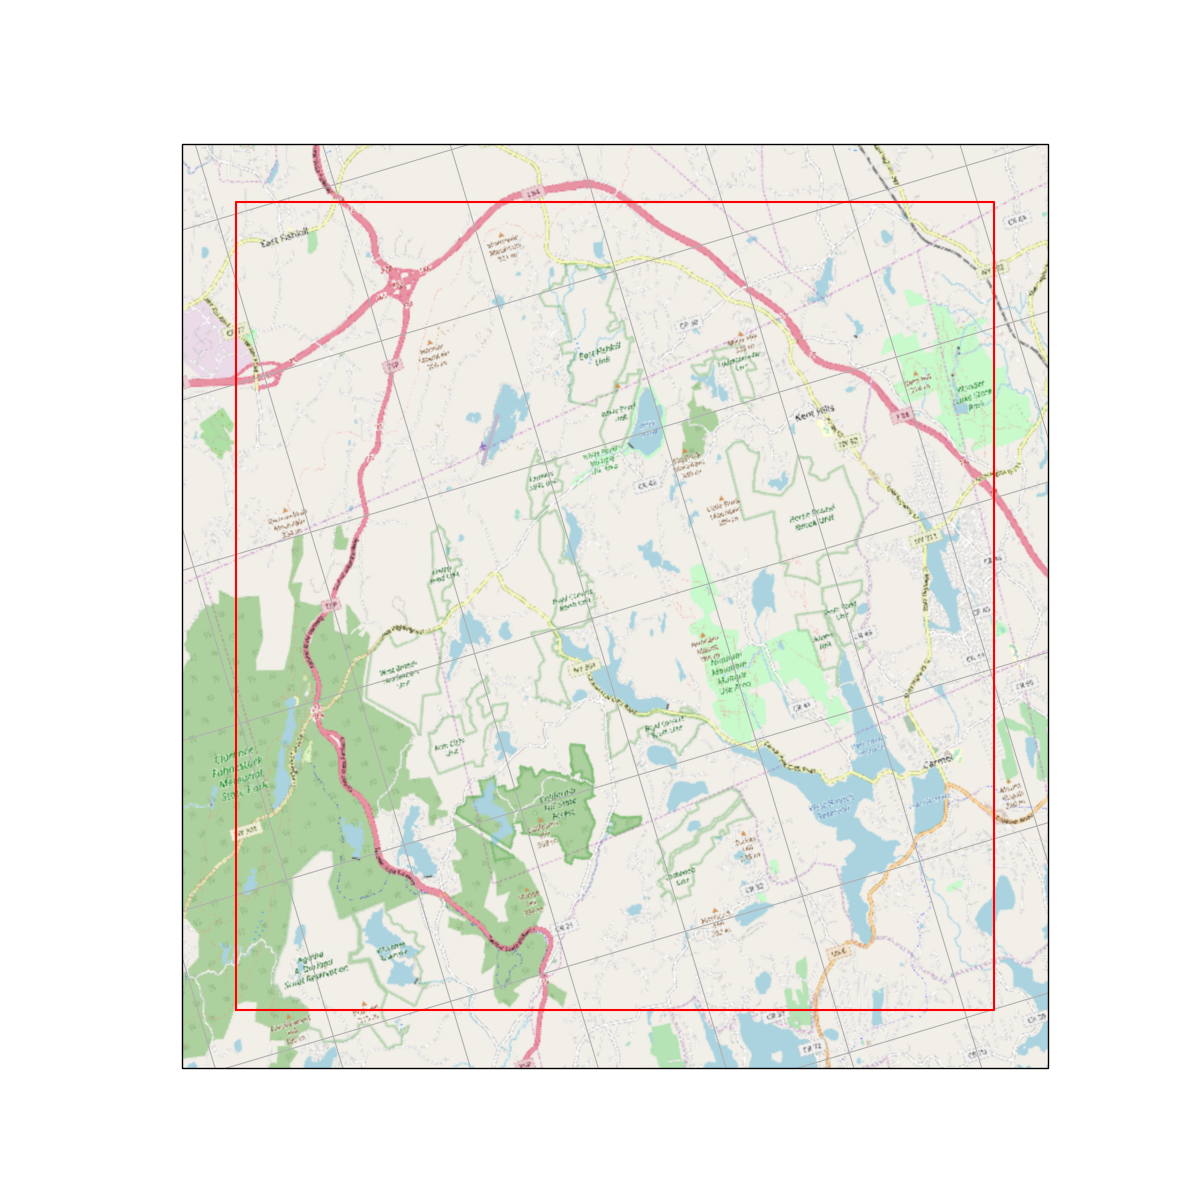

In [5]:
import os
from IPython.display import Image
Image(filename=os.path.expanduser('~/wrf-hydro-training/lesson-wps/domain.png')) 

**Step 2: Make a copy of the original domain namelist.wps**

We will copy our original domain namelist.wps that was used to create the example case and edit it. It is located at `~/wrf-hydro-training/example_case/supplemental/namelist.wps` **NOTE: Do not edit the original namelist.wps `~/wrf-hydro-training/example_case/supplemental/namelist.wps` because we will use it later to create our geogrid file.** 

In [6]:
%%bash
cp ~/wrf-hydro-training/lesson-wps/example_case/supplemental/namelist.wps ~/wrf-hydro-training/lesson-wps/namelist_edit.wps

**Step 3: Edit the `~/wrf-hydro-training/output/lesson-wps/namelist_edit.wps`**

Using your editor of choice (can be edited in Jupyter), open the `~/wrf-hydro-training/output/lesson-wps/namelist_edit.wps` file and change the *dx* and *dy* values to 
```
dx=2000.0
dy=2000.0
```

In [7]:
%%bash
docker run -v $HOME/wrf-hydro-training/lesson-wps/:/home/docker/mount wrfhydro/wps \
--namelist_path /home/docker/mount/namelist_edit.wps \
--output_dir /home/docker/mount \
--plot_only

Proj4: +proj=lcc +units=meters +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=45.0 +lon_0=-97.0
Grid center x,y: [1849500.1972706 -108771.437837 ]
Grid center lat,lon: [ 58.50955341 -63.99173649]
Domain extent: [1842000.1972705964, 1857000.1972705964, -116771.43783700376, -100771.43783700376]
Process completed after 18.65 seconds.


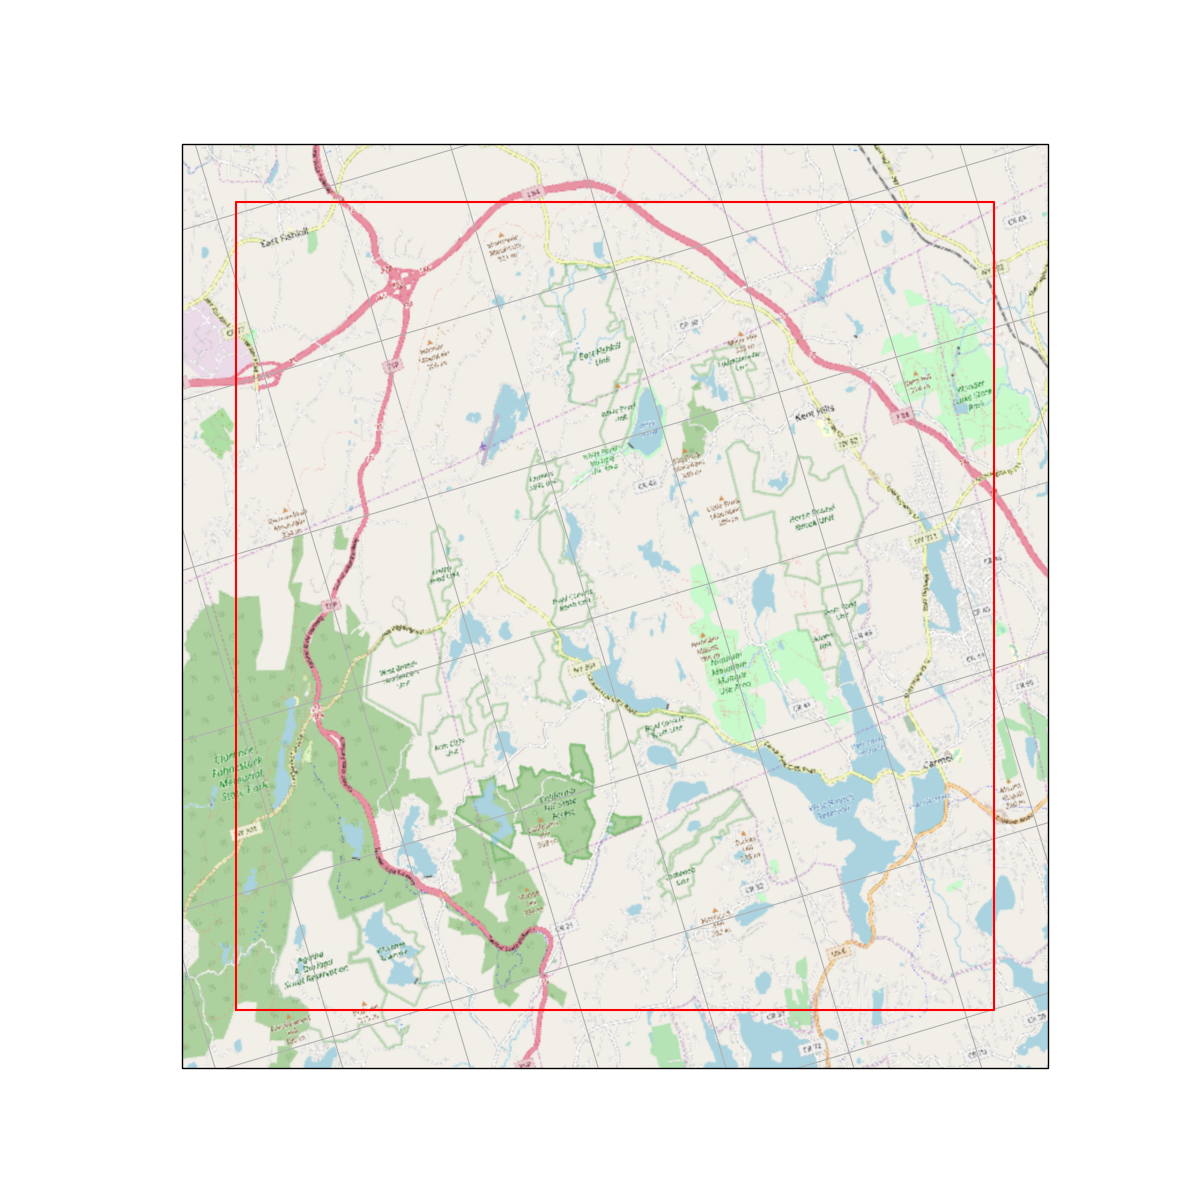

In [8]:
import os
from IPython.display import Image
Image(filename=os.path.expanduser('~/wrf-hydro-training/lesson-wps/domain.png')) 

We can see that the domain coverage has expanded but the center and size are the same. You can change any of your domain set-up by editing the variables in `namelist.wps`.


### Making the geogrid file
In this section, we will create the geogrid file using the WRF-Hydro geogrid python utility. **Note: If you would like to use this utilitiy outside of this training, the utility and all required datasets for the Continental United States are available in the *wrfhydro/wps* Docker container at https://hub.docker.com/r/wrfhydro/wps/.**

**Step 1: Copy the prepared *namelist.wps* file for the example case to the lesson-wps output folder**

We will copy over the prepared namelist.wps file from the example case to create our geogrid file. We will also rename our edited namelist.wps from the previous domain location exercise, in case you want to retain for reference.

In [9]:
%%bash
cp ~/wrf-hydro-training/lesson-wps/example_case/supplemental/namelist.wps \
~/wrf-hydro-training/lesson-wps/namelist.wps

**Step 1: Check the domain boundaries**

We will do a quick visual inspection to make sure our supplied domain boundary information is correct. 

In [10]:
%%bash
docker run -v $HOME/wrf-hydro-training/lesson-wps/:/home/docker/mount wrfhydro/wps \
--namelist_path /home/docker/mount/example_case/supplemental/namelist.wps \
--output_dir /home/docker/mount \
--plot_only

Proj4: +proj=lcc +units=meters +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=45.0 +lon_0=-97.0
Grid center x,y: [1849500.1972706 -108771.437837 ]
Grid center lat,lon: [ 58.50955341 -63.99173649]
Domain extent: [1842000.1972705964, 1857000.1972705964, -116771.43783700376, -100771.43783700376]
Process completed after 19.02 seconds.


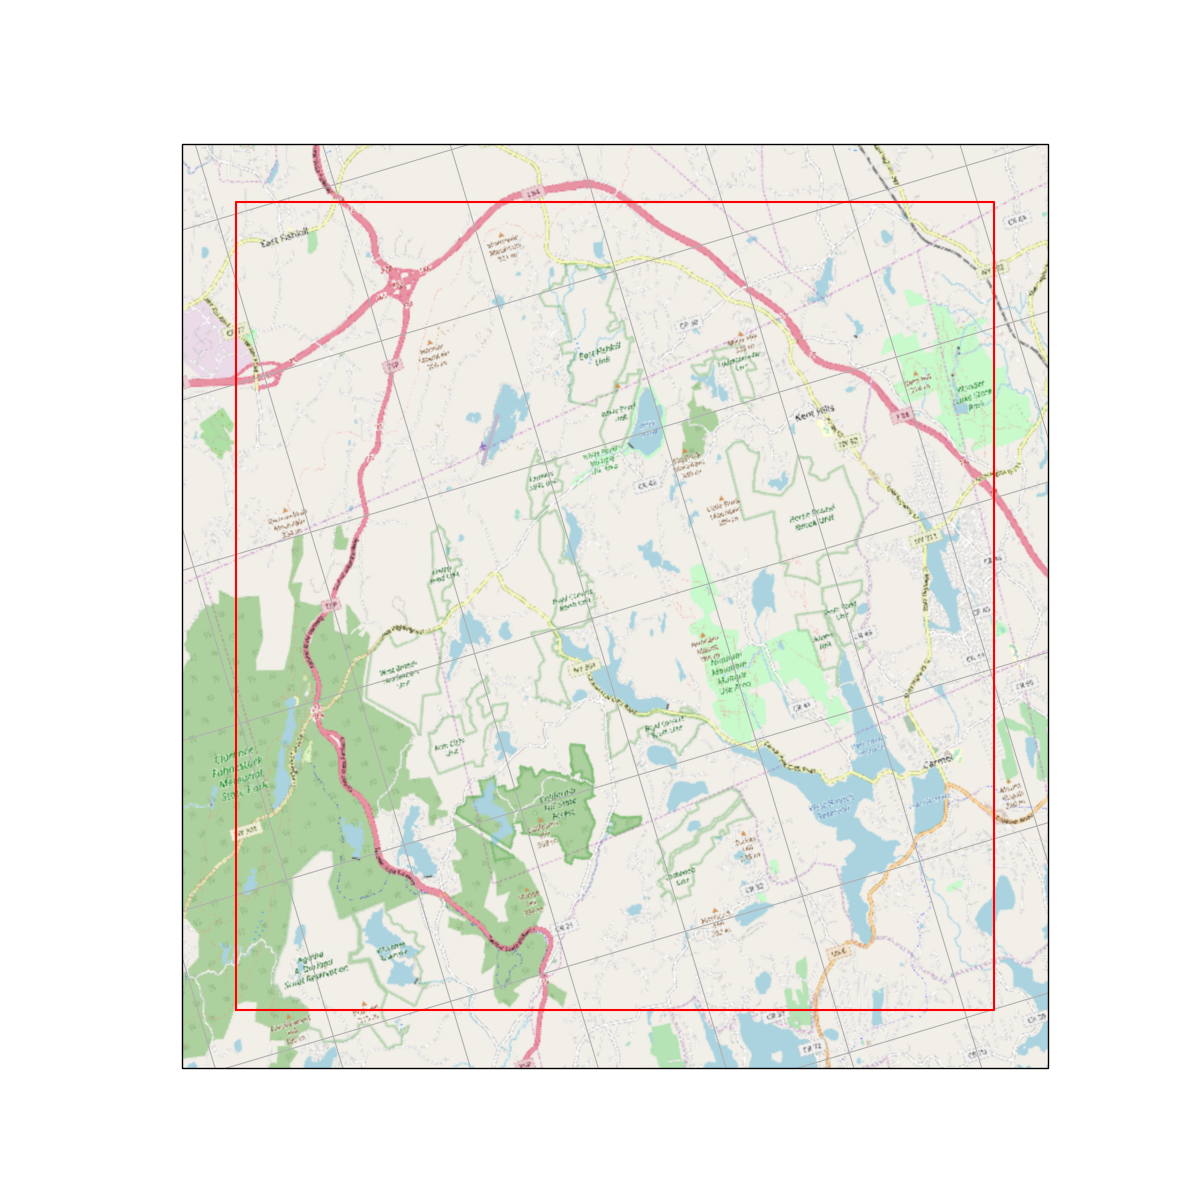

In [11]:
import os
from IPython.display import Image
Image(filename=os.path.expanduser('~/wrf-hydro-training/lesson-wps/domain.png')) 

**Step 2: Create the geogrid and wrfinput files.**

This time we will run the utility with `--plot_only` set to False. A plot of the domain will still be produced, but the geogrid.exe utility will also be executed to create the geogrid file.

The wrfinput_d01.nc is a very basic WRF-Hydro initialization file (wrfinput) from a WRF geogrid file and a set of user-specified conditions. The file contains fields of spatially uniform initial model states of soil moisture, soil temperature, soil liquid water content and skin temperature among a few other variables necessary for model cold-start initialization. This file can be used as a 'cold start' for long-term model spin-up or users can overwrite the fields in the file created. Sophisticated and WRF-savvy users can bypass this script and use the WRF utility *real.exe* to create a wrfinput file from model or reanalysis products. 

The R script used to create this file can be downloaded at https://ral.ucar.edu/projects/wrf_hydro/pre-processing-tools.

**NOTE: This R script will be replaced in the future with a Python command line utility to eliminate the R dependency.**

In [12]:
%%bash
docker run -v $HOME/wrf-hydro-training/lesson-wps/:/home/docker/mount wrfhydro/wps \
--namelist_path /home/docker/mount/example_case/supplemental/namelist.wps \
--output_dir /home/docker/mount \
--create_wrf_input

Parsed 7 entries in GEOGRID.TBL
Processing domain 1 of 1
  Processing XLAT and XLONG
  Processing MAPFAC
  Processing F and E
  Processing ROTANG
  Processing LANDUSEF
  Calculating landmask from LANDUSEF ( WATER =  16 )
  Processing HGT_M
  Processing SOILTEMP
  Processing SOILCTOP
  Processing SCT_DOM
  Processing SOILCBOT
  Processing SCB_DOM
  Processing GREENFRAC
  Processing LAI12M
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!  Successful completion of geogrid.        !
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[1] "ncks -O -4 -v XLAT_M,XLONG_M,HGT_M,SOILTEMP,LU_INDEX,MAPFAC_MX,MAPFAC_MY,GREENFRAC,LAI12M,SOILCTOP /home/docker/WRF_WPS/WPS/geo_em.d01.nc /home/docker/mount/wrfinput_d01.nc"
[1] "ncrename -O -v HGT_M,HGT /home/docker/mount/wrfinput_d01.nc /home/docker/mount/wrfinput_d01.nc"
ncrename: In total renamed 0 attributes, 0 dimensions, 0 groups, and 1 variable
[1] "ncrename -O -v XLAT_M,XLAT /home/docker/mount/wrfinput_d01.nc /home/docker/mount/wrfinput_d01.nc"
ncrename

### Inspecting the geogrid file
Now that we have created our geogrid file, we will quickly display the file header using the *ncdump* command line utility and open the file using the Python library `xarray` to visualize its contents. 

In [13]:
%%bash
ncdump -h ~/wrf-hydro-training/lesson-wps/geo_em.d01.nc

netcdf geo_em.d01 {
dimensions:
	Time = UNLIMITED ; // (1 currently)
	DateStrLen = 19 ;
	west_east = 15 ;
	south_north = 16 ;
	south_north_stag = 17 ;
	west_east_stag = 16 ;
	land_cat = 24 ;
	soil_cat = 16 ;
	month = 12 ;
variables:
	char Times(Time, DateStrLen) ;
	float XLAT_M(Time, south_north, west_east) ;
		XLAT_M:FieldType = 104 ;
		XLAT_M:MemoryOrder = "XY " ;
		XLAT_M:units = "degrees latitude" ;
		XLAT_M:description = "Latitude on mass grid" ;
		XLAT_M:stagger = "M" ;
		XLAT_M:sr_x = 1 ;
		XLAT_M:sr_y = 1 ;
	float XLONG_M(Time, south_north, west_east) ;
		XLONG_M:FieldType = 104 ;
		XLONG_M:MemoryOrder = "XY " ;
		XLONG_M:units = "degrees longitude" ;
		XLONG_M:description = "Longitude on mass grid" ;
		XLONG_M:stagger = "M" ;
		XLONG_M:sr_x = 1 ;
		XLONG_M:sr_y = 1 ;
	float XLAT_V(Time, south_north_stag, west_east) ;
		XLAT_V:FieldType = 104 ;
		XLAT_V:MemoryOrder = "XY " ;
		XLAT_V:units = "degrees latitude" ;
		XLAT_V:description = "Latitude on V grid" ;
		XLAT_V:stagger = "

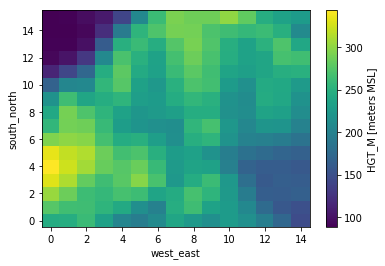

In [14]:
%matplotlib inline
import xarray as xr

geogrid = xr.open_dataset('~/wrf-hydro-training/lesson-wps/geo_em.d01.nc')
geogrid.HGT_M.plot()

**View the *wrfinput_d01.nc* file**

In [15]:
%%bash
ncdump -h ~/wrf-hydro-training/lesson-wps/wrfinput_d01.nc

netcdf wrfinput_d01 {
dimensions:
	Time = UNLIMITED ; // (1 currently)
	south_north = 16 ;
	west_east = 15 ;
	soil_layers_stag = 4 ;
variables:
	float CANWAT(Time, south_north, west_east) ;
		CANWAT:units = "kg/m^2" ;
		CANWAT:_FillValue = -1.e+36f ;
	float DZS(Time, soil_layers_stag) ;
		DZS:units = "m" ;
		DZS:_FillValue = -1.e+36f ;
	float HGT(Time, south_north, west_east) ;
		HGT:FieldType = 104 ;
		HGT:MemoryOrder = "XY " ;
		HGT:units = "meters MSL" ;
		HGT:description = "Topography height" ;
		HGT:stagger = "M" ;
		HGT:sr_x = 1 ;
		HGT:sr_y = 1 ;
	int ISLTYP(Time, south_north, west_east) ;
		ISLTYP:_FillValue = -9999 ;
	float IVGTYP(Time, south_north, west_east) ;
		IVGTYP:FieldType = 104 ;
		IVGTYP:MemoryOrder = "XY " ;
		IVGTYP:units = "category" ;
		IVGTYP:description = "Dominant category" ;
		IVGTYP:stagger = "M" ;
		IVGTYP:sr_x = 1 ;
		IVGTYP:sr_y = 1 ;
	float LAI(Time, south_north, west_east) ;
		LAI:units = "m^2/m^2" ;
		LAI:_FillValue = -1.e+36f ;
	float MAPFAC_MX(Time, 

This concludes the lesson on domain definition and initial conditions for WRF-Hydro. 